**EDA**

**Import Necessary Libraries**

In [ ]:
!pip install notebook datashader holoviews hvplot fastparquet python-snappy
!pip install panel hvplot
!pip install geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import geopy.distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import holidays
import requests
import json
import datashader as ds
import datashader.transfer_functions as tf
from geopy.distance import geodesic


/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


**Load the Datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
completed_orders = pd.read_csv('drive/MyDrive/gokada_data/nb.csv')
delivery_requests = pd.read_csv('drive/MyDrive/gokada_data/driver_locations_during_request.csv')
weather_data=pd.read_csv('drive/MyDrive/gokada_data/weather_data_lagos.csv')

In [ ]:
df = delivery_requests.merge(completed_orders, how='inner', left_on='order_id', right_on='Trip ID')
df.head()

,id,order_id,driver_id,driver_action,lat,lng,created_at,updated_at,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time
0,1,392001,243828,accepted,6.602207,3.270465,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
1,2,392001,243588,rejected,6.592097,3.287445,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
2,3,392001,243830,rejected,6.596133,3.281784,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
3,4,392001,243539,rejected,6.596142,3.280526,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
4,5,392001,171653,rejected,6.609232,3.288800,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36


Data Cleaning

In [ ]:
df.isnull().sum()

id                        0
order_id                  0
driver_id                 0
driver_action             0
lat                       0
lng                       0
created_at          1557740
updated_at          1557740
Trip ID                   0
Trip Origin               0
Trip Destination          0
Trip Start Time        2022
Trip End Time             0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1557740 non-null  int64  
 1   order_id          1557740 non-null  int64  
 2   driver_id         1557740 non-null  int64  
 3   driver_action     1557740 non-null  object 
 4   lat               1557740 non-null  float64
 5   lng               1557740 non-null  float64
 6   created_at        0 non-null        float64
 7   updated_at        0 non-null        float64
 8   Trip ID           1557740 non-null  int64  
 9   Trip Origin       1557740 non-null  object 
 10  Trip Destination  1557740 non-null  object 
 11  Trip Start Time   1555718 non-null  object 
 12  Trip End Time     1557740 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 154.5+ MB


In [ ]:
df.dropna(subset=['Trip Start Time', 'Trip End Time'], inplace=True)
df.isnull().sum()


id                        0
order_id                  0
driver_id                 0
driver_action             0
lat                       0
lng                       0
created_at          1555718
updated_at          1555718
Trip ID                   0
Trip Origin               0
Trip Destination          0
Trip Start Time           0
Trip End Time             0
dtype: int64

In [ ]:
columns_to_drop = ['created_at', 'updated_at']
df = df.drop(columns=columns_to_drop)
df.isnull().sum()

id                  0
order_id            0
driver_id           0
driver_action       0
lat                 0
lng                 0
Trip ID             0
Trip Origin         0
Trip Destination    0
Trip Start Time     0
Trip End Time       0
dtype: int64

In [ ]:
# Convert timestamps to datetime
df['Trip Start Time'] = pd.to_datetime(df['Trip Start Time'])
df['Trip End Time'] = pd.to_datetime(df['Trip End Time'])

**Exploratory Data Analysis**

In [ ]:
df.describe()

,id,order_id,driver_id,lat,lng,Trip ID,Trip Start Time,Trip End Time
count,1.555718e+06,1.555718e+06,1.555718e+06,1.555718e+06,1.555718e+06,1.555718e+06,1555718,1555718
mean,7.788216e+05,4.191817e+05,2.341504e+05,6.536075e+00,3.378822e+00,4.191817e+05,2021-07-05 15:00:07.946958080,2021-07-05 16:01:53.159771392
min,1.000000e+00,3.920010e+05,1.219810e+05,6.409333e+00,3.076561e+00,3.920010e+05,2021-07-01 06:39:51,2021-07-01 07:25:03
25%,3.893292e+05,4.067520e+05,2.429970e+05,6.498708e+00,3.348810e+00,4.067520e+05,2021-07-03 10:06:06,2021-07-03 10:57:06
50%,7.788565e+05,4.216870e+05,2.435890e+05,6.544250e+00,3.363503e+00,4.216870e+05,2021-07-06 10:27:06,2021-07-06 11:14:43
75%,1.168201e+06,4.293130e+05,2.440560e+05,6.593277e+00,3.385168e+00,4.293130e+05,2021-07-07 11:50:31,2021-07-07 12:45:25
max,1.557740e+06,5.179480e+05,2.478770e+05,7.702536e+00,8.515414e+00,5.179480e+05,2022-02-27 09:07:59,2022-02-27 09:17:41
std,4.496507e+05,1.444435e+04,2.270439e+04,5.995268e-02,5.329471e-02,1.444435e+04,NaN,NaN


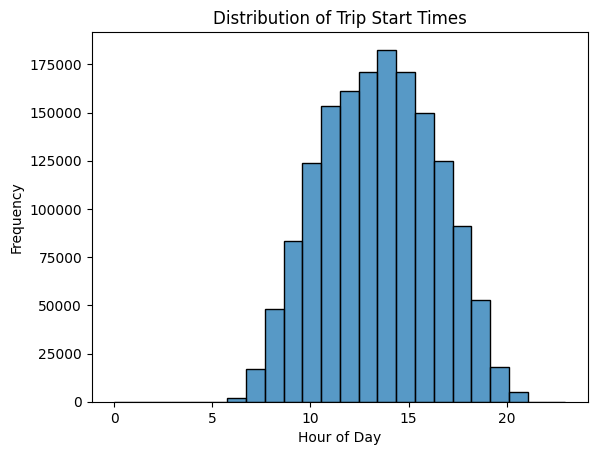

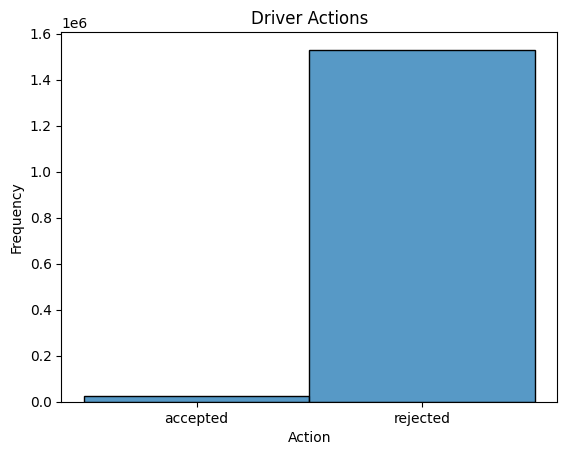

In [ ]:
# Distribution plots
sns.histplot(df['Trip Start Time'].dt.hour, kde=False, bins=24)
plt.title('Distribution of Trip Start Times')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

sns.histplot(df['driver_action'], kde=False)
plt.title('Driver Actions')
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.show()

**Feature Engineering**

In [ ]:
# Adding holiday information
holidays = holidays.NG()
df['Is Holiday'] = df['Trip Start Time'].apply(lambda x: x in holidays)

# Adding weekday/weekend information
df['Day of Week'] = df['Trip Start Time'].dt.dayofweek
df['Is Weekend'] = df['Day of Week'] >= 5

In [ ]:
df['Is Holiday'].unique()

array([False])

In [ ]:
df['Is Weekend'].unique()

array([False,  True])

In [ ]:
df['Day of Week'].unique()

array([3, 4, 6, 5, 2, 1, 0], dtype=int32)

Add rainfall data

In [ ]:
weather_data.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2021-07-01,27.8,24.0,33.0,0.0,NaN,253.0,10.1,NaN,1014.7,NaN
1,2021-07-02,27.5,24.9,31.2,NaN,NaN,248.0,9.5,NaN,1014.0,NaN
2,2021-07-03,25.9,23.0,29.5,NaN,NaN,258.0,11.0,NaN,1014.6,NaN
3,2021-07-04,25.7,22.0,31.0,NaN,NaN,257.0,8.8,NaN,1015.5,NaN
4,2021-07-05,27.6,24.0,32.0,NaN,NaN,242.0,8.8,NaN,1015.6,NaN


In [ ]:
weather_data['time'] = pd.to_datetime(weather_data['time'])

In [ ]:
df['trip_start_date'] = df['Trip Start Time'].dt.date

In [ ]:
weather_data['date'] = weather_data['time'].dt.date

In [ ]:
df = df.merge(weather_data[['date', 'prcp']], left_on='trip_start_date', right_on='date', how='left')
df.drop(columns=['date'], inplace=True)
df.head()

,id,order_id,driver_id,driver_action,lat,lng,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Is Holiday,Day of Week,Is Weekend,trip_start_date,prcp
0,1,392001,243828,accepted,6.602207,3.270465,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,0.0
1,2,392001,243588,rejected,6.592097,3.287445,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,0.0
2,3,392001,243830,rejected,6.596133,3.281784,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,0.0
3,4,392001,243539,rejected,6.596142,3.280526,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,0.0
4,5,392001,171653,rejected,6.609232,3.288800,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,0.0


In [ ]:
df['rain'] = df['prcp'].apply(lambda x: 'rain' if x > 0 else 'no_rain')
df.drop(columns=['prcp'], inplace=True)
df.head()

,id,order_id,driver_id,driver_action,lat,lng,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Is Holiday,Day of Week,Is Weekend,trip_start_date,rain
0,1,392001,243828,accepted,6.602207,3.270465,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,no_rain
1,2,392001,243588,rejected,6.592097,3.287445,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,no_rain
2,3,392001,243830,rejected,6.596133,3.281784,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,no_rain
3,4,392001,243539,rejected,6.596142,3.280526,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,no_rain
4,5,392001,171653,rejected,6.609232,3.288800,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,False,3,False,2021-07-01,no_rain


**Feature Extraction and Scaling**

In [ ]:
# Split 'Trip Origin' into 'Origin Lat' and 'Origin Lng'
df[['Origin Lat', 'Origin Lng']] = df['Trip Origin'].str.split(",", expand=True).astype(float)
# Split 'Trip Destination' into 'Destination Lat' and 'Destination Lng'
df[['Destination Lat', 'Destination Lng']] = df['Trip Destination'].str.split(",", expand=True).astype(float)

In [ ]:
# Scaling numerical features
scaler = StandardScaler()
df[['lat', 'lng']] = scaler.fit_transform(df[['lat', 'lng']])
df[['Origin Lat', 'Origin Lng', 'Destination Lat', 'Destination Lng']] = scaler.fit_transform(df[['Origin Lat', 'Origin Lng', 'Destination Lat', 'Destination Lng']])


distance between driver and trip origin

In [ ]:
# Identify invalid latitude values
invalid_lat_rows = df[(df['lat'] < -90) | (df['lat'] > 90) | (df['Origin Lat'] < -90) | (df['Origin Lat'] > 90)]
print("Invalid latitude rows:")
print(invalid_lat_rows)

Invalid latitude rows:
              id  order_id  driver_id driver_action       lat       lng  \
1542137  1544160    447998     244192      accepted -1.261419 -1.277787   

         Trip ID Trip Origin             Trip Destination     Trip Start Time  \
1542137   447998         1,1  6.441535699999999,3.8539967 2021-07-09 18:16:39   

              Trip End Time  Is Holiday  Day of Week  Is Weekend  \
1542137 2021-07-09 19:04:12       False            4       False   

        trip_start_date  rain  Origin Lat  Origin Lng  Destination Lat  \
1542137      2021-07-09  rain  -91.859598  -45.117787        -1.293694   

         Destination Lng  
1542137         6.284089  


In [ ]:
# Remove rows with invalid latitude values
df = df[(df['lat'] >= -90) & (df['lat'] <= 90) & (df['Origin Lat'] >= -90) & (df['Origin Lat'] <= 90)]

In [ ]:
from geopy.distance import geodesic

df['driver_proximity'] = df.apply(
    (lambda row: geodesic(
        (row['lat'], row['lng']),
        (row['Origin Lat'], row['Origin Lng'])
    ).km),
    axis=1
)



In [ ]:
df.head()

,id,order_id,driver_id,driver_action,lat,lng,Trip ID,Trip Origin,Trip Destination,Trip Start Time,...,Is Holiday,Day of Week,Is Weekend,trip_start_date,rain,Origin Lat,Origin Lng,Destination Lat,Destination Lng,driver_proximity
0,1,392001,243828,accepted,1.103065,-2.033171,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,2021-07-01,no_rain,1.085057,-1.960046,-1.176457,0.108505,8.378837
1,2,392001,243588,rejected,0.934442,-1.714569,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,2021-07-01,no_rain,1.085057,-1.960046,-1.176457,0.108505,31.997836
2,3,392001,243830,rejected,1.001765,-1.820782,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,2021-07-01,no_rain,1.085057,-1.960046,-1.176457,0.108505,18.029974
3,4,392001,243539,rejected,1.001902,-1.844383,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,2021-07-01,no_rain,1.085057,-1.960046,-1.176457,0.108505,15.819918
4,5,392001,171653,rejected,1.220243,-1.689141,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,2021-07-01,no_rain,1.085057,-1.960046,-1.176457,0.108505,33.653025


In [ ]:
file_path = '/content/drive/My Drive/gokada_data/df_rich.csv'
df.to_csv(file_path, index=False)

computing distance, duration and speed between trip origin and destination

compute speed on table 1

In [ ]:
# Split 'Trip Origin' into 'Origin Lat' and 'Origin Lng'
completed_orders[['Origin Lat', 'Origin Lng']] = completed_orders['Trip Origin'].str.split(",", expand=True).astype(float)

completed_orders[['Destination Lat', 'Destination Lng']] = completed_orders['Trip Destination'].str.split(",", expand=True).astype(float)

In [ ]:
# Scaling numerical features
scaler = StandardScaler()
completed_orders[['Origin Lat', 'Origin Lng', 'Destination Lat', 'Destination Lng']] = scaler.fit_transform(completed_orders[['Origin Lat', 'Origin Lng', 'Destination Lat', 'Destination Lng']])

In [ ]:
completed_orders.dropna(subset=['Trip Start Time', 'Trip End Time'], inplace=True)
completed_orders.isnull().sum()

Trip ID             0
Trip Origin         0
Trip Destination    0
Trip Start Time     0
Trip End Time       0
Origin Lat          0
Origin Lng          0
Destination Lat     0
Destination Lng     0
Distance            0
dtype: int64

In [ ]:
# Convert timestamps to datetime
completed_orders['Trip Start Time'] = pd.to_datetime(completed_orders['Trip Start Time'])
completed_orders['Trip End Time'] = pd.to_datetime(completed_orders['Trip End Time'])

In [ ]:
from geopy.distance import geodesic

completed_orders['Distance'] = completed_orders.apply(
    (lambda row: geodesic(
        (row['Origin Lat'], row['Origin Lng']),
        (row['Destination Lat'], row['Destination Lng'])
    ).km),
    axis=1
)

completed_orders['Duration'] = (completed_orders['Trip End Time'] - completed_orders['Trip Start Time']).dt.total_seconds() / 3600

completed_orders['Speed'] = completed_orders['Distance'] / completed_orders['Duration']

In [ ]:
completed_orders.to_csv('orders_rich.csv', index=False)

In [ ]:
completed_orders.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Origin Lat,Origin Lng,Destination Lat,Destination Lng,Distance,Duration,Speed
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37,-0.209309,-0.231990,1.078206,-0.604732,148.289108,0.025833,5740.223535
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28,-0.952268,0.625320,-0.834229,0.603124,13.283907,0.490000,27.110014
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23,0.974031,-0.654482,-0.145728,-0.471663,125.477886,0.689167,182.071902
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42,0.406545,-0.338365,0.511149,-0.449173,16.909475,0.226389,74.692162
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,0.678956,-1.337655,-0.645245,-0.162231,196.366883,0.060278,3257.699443


Compute **the number of riders and order in circles of 500m**from accepted
and unfulfill ed orders

In [ ]:
import pandas as pd

delivery_500m = df[df['driver_proximity'] <= 0.5]

# Compute the total number of nearby drivers for each delivery request
total_nearby_drivers = delivery_500m.groupby('order_id')['driver_id'].nunique().reset_index(name='Total Nearby Drivers')

# Compute the number of nearby drivers who accepted the delivery requests
accepted_drivers = delivery_500m[delivery_500m['driver_action'] == 'accepted']
nearby_drivers_accepted = accepted_drivers.groupby('order_id')['driver_id'].nunique().reset_index(name='Nearby Accepted Drivers')

# Compute the number of nearby drivers who rejected the delivery requests
rejected_drivers = delivery_500m[delivery_500m['driver_action'] == 'rejected']
nearby_drivers_rejected = rejected_drivers.groupby('order_id')['driver_id'].nunique().reset_index(name='Nearby Rejected Drivers')



In [ ]:
nearby_drivers_accepted['Nearby Accepted Drivers'].describe()

count    32.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: Nearby Accepted Drivers, dtype: float64

In [ ]:
nearby_drivers_rejected['Nearby Rejected Drivers'].describe()

count    312.000000
mean       1.237179
std        0.611909
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: Nearby Rejected Drivers, dtype: float64

In [ ]:
total_nearby_drivers['Total Nearby Drivers'].describe()

count    334.000000
mean       1.236527
std        0.653736
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: Total Nearby Drivers, dtype: float64

**Advanced visualization**

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
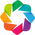

In [ ]:
import datashader as ds, pandas as pd
import datashader.transfer_functions as tf
import holoviews as hv, colorcet as cc
from holoviews.element.tiles import EsriImagery
from datashader.utils import export_image
import numpy as np
from holoviews.operation.datashader import datashade, shade, dynspread
hv.extension('bokeh')


In [ ]:
# Clustering starting locations
kmeans = KMeans(n_clusters=10)
df['Start Cluster'] = kmeans.fit_predict(df[['Origin Lat', 'Origin Lng']])

# Clustering destination locations
df['End Cluster'] = kmeans.fit_predict(df[['Destination Lat', 'Destination Lng']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


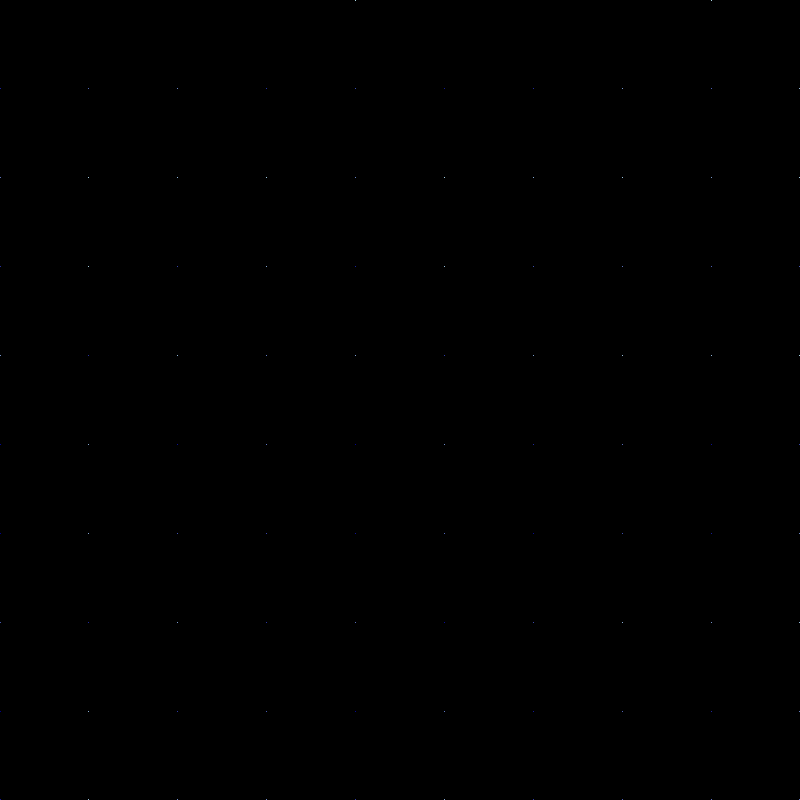

In [ ]:
# Visualizing with datashader
cvs = ds.Canvas(plot_width=800, plot_height=800)
agg = cvs.points(df, 'Start Cluster', 'End Cluster', ds.count())
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], how='eq_hist')
tf.set_background(img, "black").to_pil()

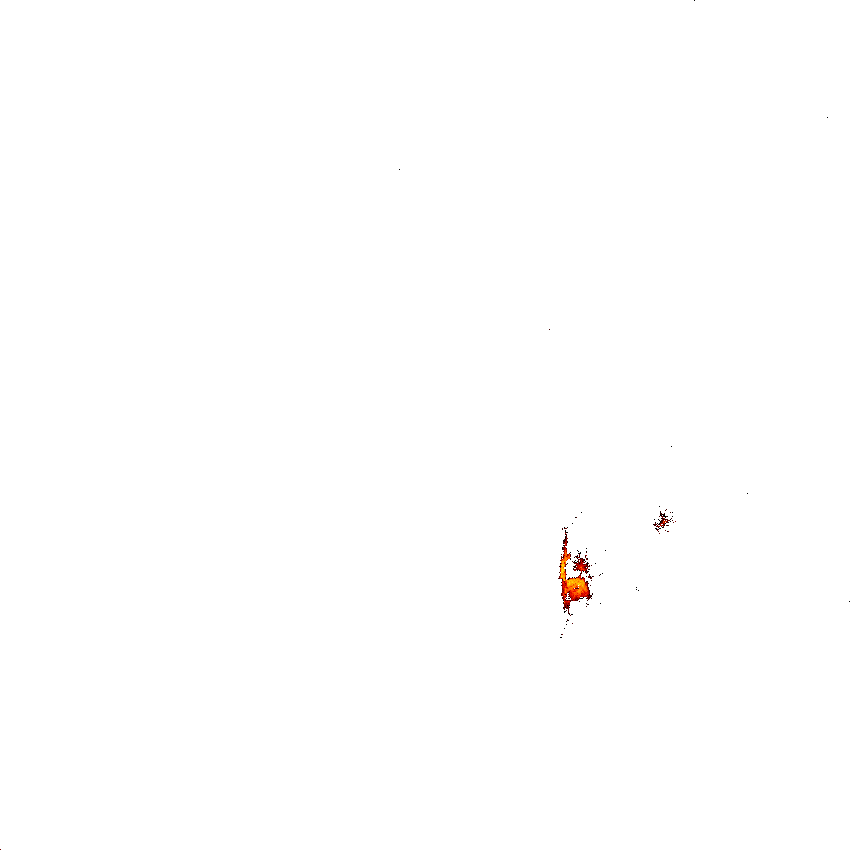

In [ ]:
cvs = ds.Canvas(plot_width=850, plot_height=850)
agg = cvs.points(completed_orders, 'Origin Lat', 'Origin Lng', ds.count())
img = tf.shade(agg, cmap=colorcet.fire, how='log')
img

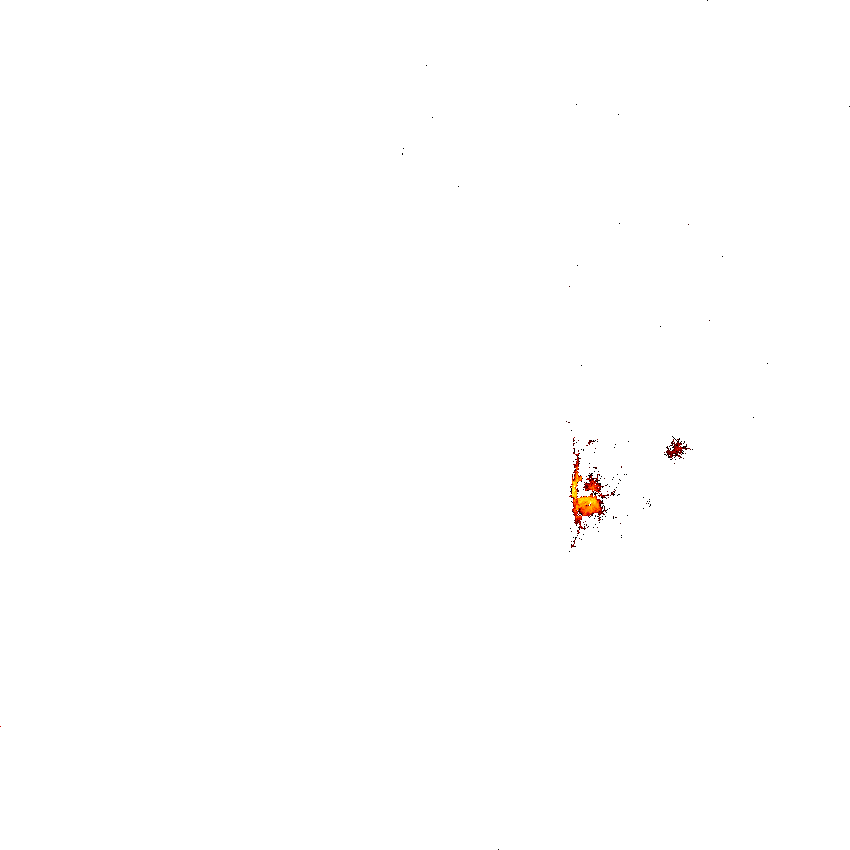

In [ ]:
cvs = ds.Canvas(plot_width=850, plot_height=850)
agg = cvs.points(completed_orders, 'Destination Lat', 'Destination Lng', ds.count())
img = tf.shade(agg, cmap=colorcet.fire, how='log')
img

In [ ]:
data=df.copy()

In [ ]:
columns_to_drop = ['Distance', 'Duration', 'Speed']
data = data.drop(columns=columns_to_drop)
data.head()

,id,order_id,driver_id,driver_action,lat,lng,Trip ID,Trip Origin,Trip Destination,Trip Start Time,...,Is Holiday,Day of Week,Is Weekend,Origin Lat,Origin Lng,Destination Lat,Destination Lng,driver_proximity,Start Cluster,End Cluster
0,1,392001,243828,accepted,1.103065,-2.033171,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,1.085057,-1.960046,-1.176457,0.108505,8.378837,9,8
1,2,392001,243588,rejected,0.934442,-1.714569,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,1.085057,-1.960046,-1.176457,0.108505,31.997836,9,8
2,3,392001,243830,rejected,1.001765,-1.820782,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,1.085057,-1.960046,-1.176457,0.108505,18.029974,9,8
3,4,392001,243539,rejected,1.001902,-1.844383,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,1.085057,-1.960046,-1.176457,0.108505,15.819918,9,8
4,5,392001,171653,rejected,1.220243,-1.689141,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,...,False,3,False,1.085057,-1.960046,-1.176457,0.108505,33.653025,9,8


In [ ]:
data['driver_action'] = data['driver_action'].astype('category')

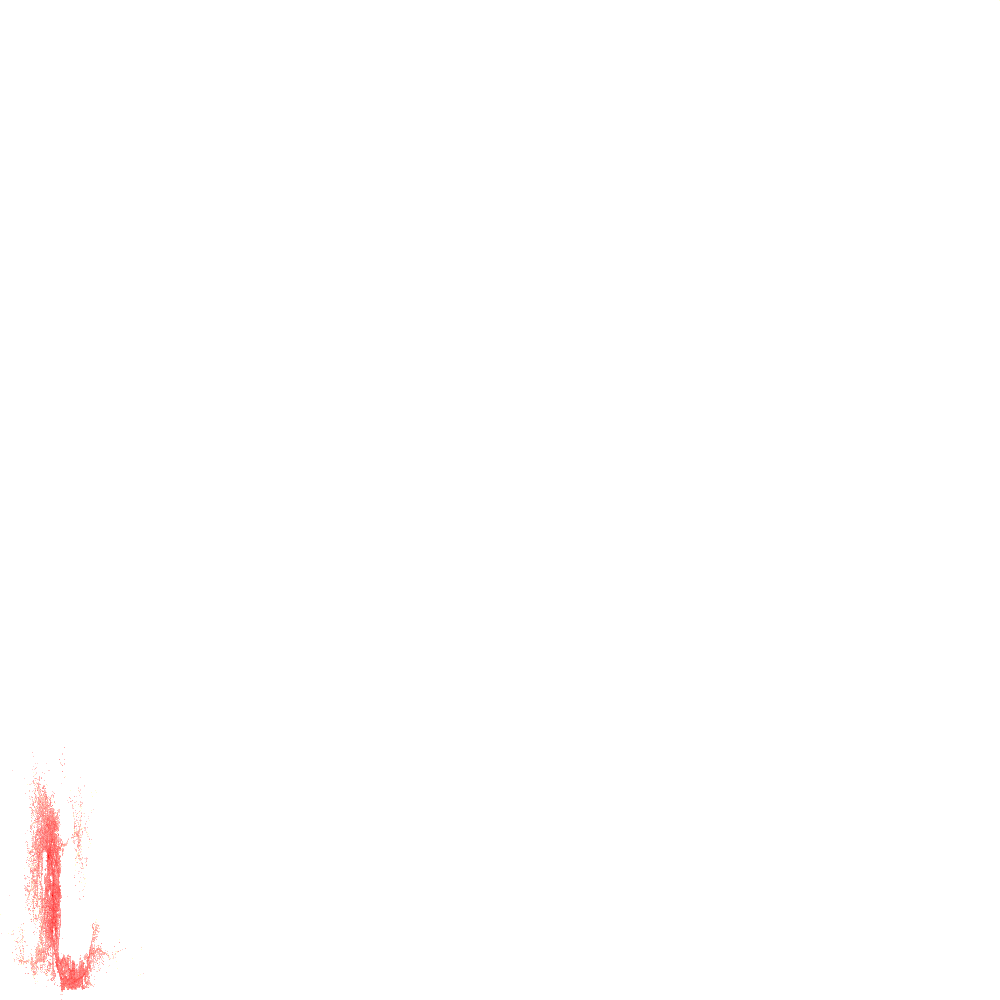

In [ ]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000, x_range=(data['lng'].min(), data['lng'].max()), y_range=(data['lat'].min(), data['lat'].max()))
agg = cvs.points(data, 'lng', 'lat', ds.count_cat('driver_action'))
img = tf.shade(agg, color_key={'accepted': 'yellow', 'rejected': 'red'}, how='log')
export_image(img, filename="driver_proximity")
img
